# Measurements of Relativistic Corrections

Set up the appropriate paths.

In [1]:
import os, sys

current_file_dir = os.getcwd()
sys.path.insert(0, "".join([current_file_dir, "/../"]))
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

from config.program import SciFormatter, data_dir, stylesheet

Import the appropriate packages.

In [2]:
import glob
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
from nbodykit.cosmology import Planck15

from horizonground.clustering_modification import (
    relativistic_correction_func,
    relativistic_correction_value,
)

plt.style.use(stylesheet)

model = np.random.choice(["PLE_model"])  # "PLE_model", "hybrid_model"
threshold = "-25.0"  # "-22.0", "-25.0"

print("Selected: {}, magnitude limit {}".format(model, threshold))

publication_dir = data_dir/"output"/"publication"/model

Selected: PLE_model, magnitude limit -25.0


## Relativistic correction quantiles

Load samples of the relativistic correction contributions at densly sampled redshifts and determine their quantiles.

In [3]:
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

In [4]:
dense_redshifts = []
g1_quantiles, g2_quantiles = defaultdict(list), defaultdict(list)
for chain_file in sorted(glob.glob("/".join([
        str(publication_dir), "dense_points", "correction", "relcrct_z*m{}*".format(threshold)
    ]))):
    dense_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        g1_q = corner.quantile(distilled[:, 0], q=quantile_levels)
        g2_q = corner.quantile(distilled[:, 1], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        g1_quantiles[sigma_level].append(g1_q[sigma_level_idx])
        g2_quantiles[sigma_level].append(g2_q[sigma_level_idx])

In [5]:
discontinuity_pos = np.searchsorted(dense_redshifts, 2.2)
low_redshift_part = slice(0, discontinuity_pos)
high_redshift_part = slice(discontinuity_pos, None)

## Relativistic correction measurements

Load samples of the relativistic correction contributions in eBOSS QSO LF redshift bins and determine the estimates with uncertainties.

In [6]:
estimate_levels = [0.158655, 0.5, 0.841345]

In [7]:
measured_redshifts = []
g1_estimates, g2_estimates = defaultdict(list), defaultdict(list)
for chain_file in sorted(glob.glob("/".join([
        str(publication_dir), "eBOSS_binning", "relcrct_z*m{}*".format(threshold)
    ]))):
    measured_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        g1_e = corner.quantile(distilled[:, 0], q=estimate_levels)
        g2_e = corner.quantile(distilled[:, 1], q=estimate_levels)
    for sigma_level_idx, sigma_level in enumerate([-1, 0, 1]):
        g1_estimates[sigma_level].append(g1_e[sigma_level_idx])
        g2_estimates[sigma_level].append(g2_e[sigma_level_idx])

## Relativistic correction contributions

In [8]:
f_dense = Planck15.scale_independent_growth_rate(dense_redshifts)
f_bins = Planck15.scale_independent_growth_rate(measured_redshifts)

comparison_redshifts = np.linspace(0., 4., 51)
f_comp = Planck15.scale_independent_growth_rate(comparison_redshifts)

In [9]:
g_1_bare = np.asarray([
    relativistic_correction_func(1, evolution_bias=lambda z: 0., magnification_bias=lambda z: 0.)(z)
    for z in comparison_redshifts
])
g_2_bare = np.asarray([
    relativistic_correction_func(2, evolution_bias=lambda z: 0., magnification_bias=lambda z: 0.)(z)
    for z in comparison_redshifts
])

In [10]:
g_1_diffuse = np.asarray([
    relativistic_correction_func(1, evolution_bias=lambda z: 0., magnification_bias=lambda z: 0.4)(z)
    for z in comparison_redshifts
])
g_2_diffuse = np.asarray([
    relativistic_correction_func(2, evolution_bias=lambda z: 0., magnification_bias=lambda z: 0.4)(z)
    for z in comparison_redshifts
])

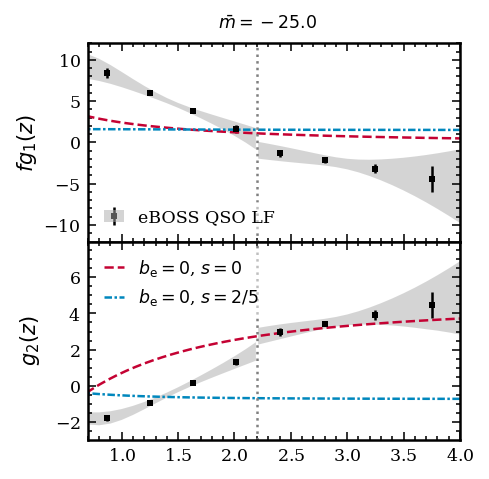

In [11]:
ALPHA = 0.5

fig = plt.figure(
    "relativistic correction functions", 
    figsize=(3.2, 3.5), dpi=150, constrained_layout=True
)

order_1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)

order_1.errorbar(
    measured_redshifts, f_bins*np.asarray(g1_estimates[0]),
    yerr=f_bins*np.array([
        np.asarray(g1_estimates[0]) - np.asarray(g1_estimates[-1]), 
        np.asarray(g1_estimates[1]) - np.asarray(g1_estimates[0]),
    ]),
    fmt='s', label='eBOSS QSO LF'
)

for idx, part in enumerate([low_redshift_part, high_redshift_part]):
    order_1.fill_between(
        dense_redshifts[part],
        f_dense[part]*np.asarray(g1_quantiles[-2])[part], 
        f_dense[part]*np.asarray(g1_quantiles[2])[part],
        facecolor='0.67', alpha=ALPHA,
    )

order_1.plot(
    comparison_redshifts, f_comp*g_1_bare, ls='--'
)
order_1.plot(
    comparison_redshifts, f_comp*g_1_diffuse, dashes=[3, 1, 1, 1]
)

order_1.axvline(x=2.2, ls=':', c='0.5')

handles, labels = order_1.get_legend_handles_labels()
patch = mpatches.Patch(ec='none', fc='0.67', alpha=ALPHA)
handles[-1] = (handles[-1], patch)

order_1.legend(
    reversed(handles), reversed(labels), loc='lower left',
    frameon=True, framealpha=0.5, edgecolor='none'
)
order_1.tick_params(axis='x', which='both', labelbottom=False)
order_1.yaxis.set_minor_locator(AutoMinorLocator())
order_1.set_ylim(-12., 12.)
order_1.set_ylabel(r"$f g_1(z)$", labelpad=2)

order_2 = plt.subplot2grid((4, 1), (2, 0), rowspan=2, sharex=order_1)

order_2.errorbar(
    measured_redshifts, f_bins*np.asarray(g2_estimates[0]),
    yerr=f_bins*np.array([
        np.asarray(g2_estimates[0]) - np.asarray(g2_estimates[-1]), 
        np.asarray(g2_estimates[1]) - np.asarray(g2_estimates[0])
    ]),
    fmt='s'
)

for idx, part in enumerate([low_redshift_part, high_redshift_part]):
    order_2.fill_between(
        dense_redshifts[part],
        f_dense[part]*np.asarray(g2_quantiles[-2])[part], 
        f_dense[part]*np.asarray(g2_quantiles[2])[part],
        facecolor='0.67', alpha=ALPHA,
    )

order_2.plot(
    comparison_redshifts, g_2_bare, ls='--',
    label=r"$b_\mathrm{e} = 0$, $s = 0$"
)
order_2.plot(
    comparison_redshifts, g_2_diffuse, dashes=[3, 1, 1, 1],
    label=r"$b_\mathrm{e} = 0$, $s = 2/5$"
)

order_2.axvline(x=2.2, ls=':', c='0.5')

order_2.legend(
    loc='upper left',
    frameon=True, framealpha=0.5, edgecolor='none'
)
order_2.set_xticks(np.arange(0., 5., step=0.5))
order_2.set_yticks(np.arange(-12., 12., step=2.))
order_2.xaxis.set_minor_locator(AutoMinorLocator())
order_2.yaxis.set_minor_locator(AutoMinorLocator())
order_2.set_xlim(min(dense_redshifts), max(dense_redshifts))
order_2.set_ylim(-3., 7.99)
order_2.set_ylabel(r"$g_2(z)$", labelpad=6)

fig.suptitle(r"$\bar{{m}} = {}$".format(threshold), fontsize='small', y=0.935)
fig.savefig(
    publication_dir/"gallery"/"relativistic_correction_breakdown_m{}.pdf".format(threshold)
)